In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

# EXPECTED OUTPUT
# 2.0.0-beta1 (or later)


2.4.0


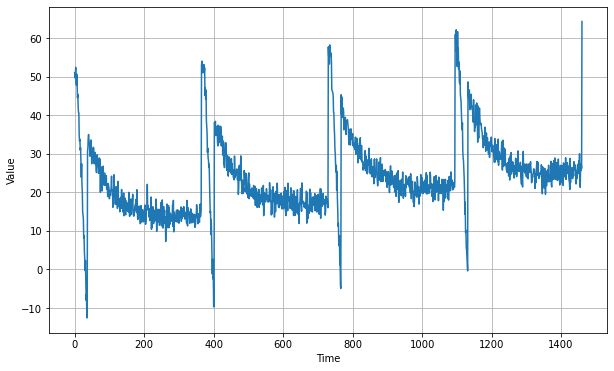

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Now that we have the time series, let's split it so we can start forecasting

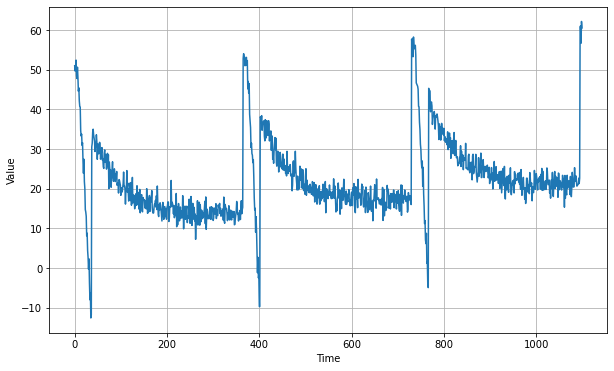

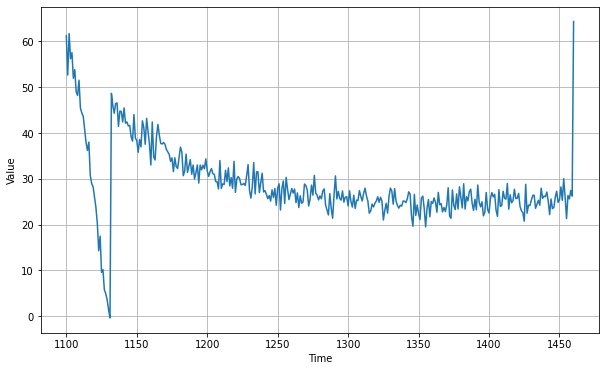

In [8]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:] # series 대신 x_valid, x_train으로 적어놨다.
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [9]:
naive_forecast = series[split_time-1:-1]

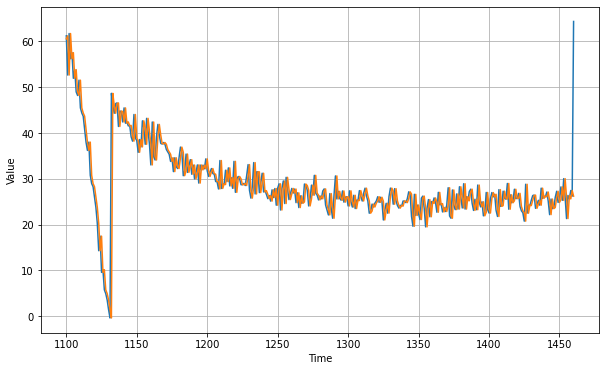

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay

Let's zoom in on the start of the validation period:

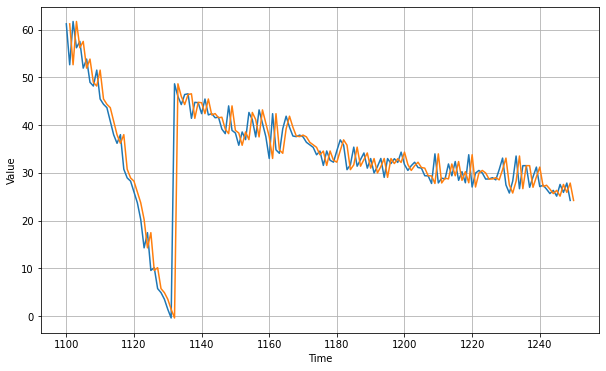

In [15]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151) # 얘가 예측한거

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [16]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) # mse : 오차의 제곱을 다 더하고 평균낸거
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) # mae : 차이를 절대값으로 만든 걸 다 더하고 평균낸거
# Expected Output
# 19.578304
# 2.6011968

19.578306
2.6011972


That's our baseline, now let's try a moving average:

In [31]:
def moving_average_forecast(series, window_size): # 이동 평균을 이용해 노이즈를 제거할 수 있다. 평균값으로 예측하는거니 어찌보면 당연한게 아닐까
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  count = 0
  for time in range(len(series) - window_size): # 맨 뒤에 window_size만큼 있는 구역을 예측하기 위해 이동 평균 구하는 구간에 window_size만큼 제외
    forecast.append(series[time:time + window_size].mean()) # 30일 구간 기준으로 평균 구한걸 forecast에 넣음
    count = count + 1
  print(count) # 1431이 나온다. 원래 1461개인데 마지막 30개가 빠졌다는 사실을 알 수 있다
  return np.array(forecast)

1431
361


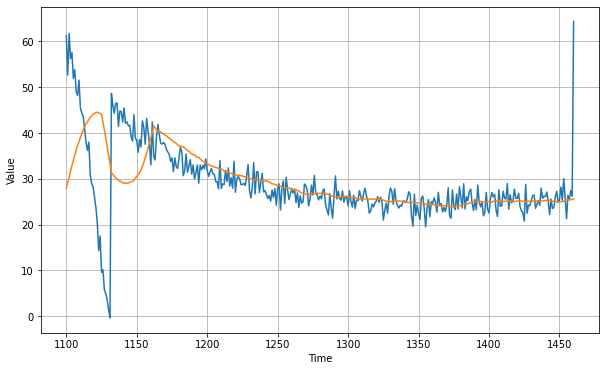

In [34]:
moving_avg = moving_average_forecast(series ,30)[split_time - 30:] # 전체 구간에서 구한 이동 평균 중 검증 세트 시작점의 30 time 이전 세트부터 마지막까지 가져옴
print(len(moving_avg)) # 1100을 기준으로 나눴는데 1070부터 이동 평균의 최종 크기인 1461까지의 이동 평균 리스트를 가져왔다. 그래서 361개다. 

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [35]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) 
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) # 훨씬 적게 나오는데 뭐지 이거
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

19.578306
2.6011972


1096
1096


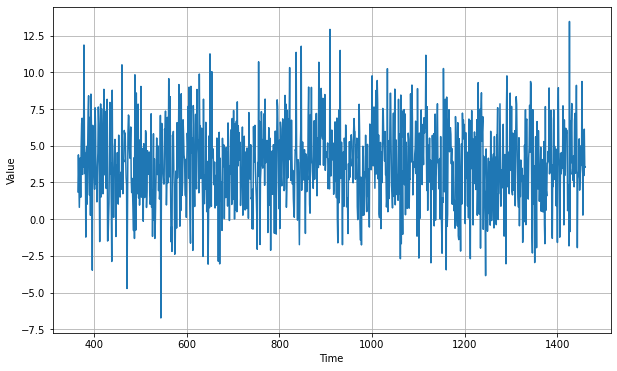

In [37]:
# 패턴으로 튀어나오는거 없애기
diff_series = (series[365:] - series[:-365]) # (2년차~맨 마지막) - (1년차 ~ 뒤에서 2년차) 데이터끼리 삭제 = 패턴으로 튀어나오는거 삭제됨
diff_time = time[365:]
print(len(diff_series)) # 크기는 1461-365 = 1096
print(len(diff_time)) # 1461에서 365 빼면 1096 나온다.

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

1066
361
361


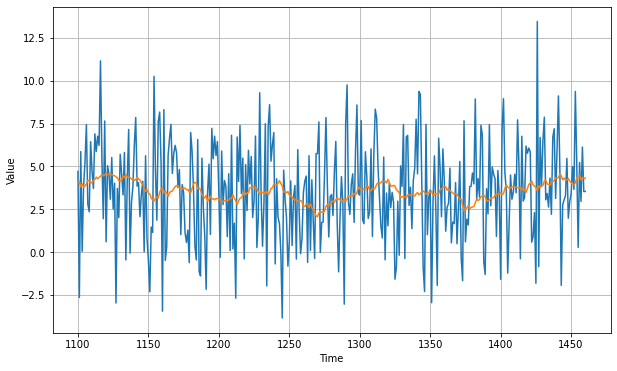

In [40]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:] # 평균 구하는 구간만큼 뒤의 리스트에서 빼줘야한다. split_time - (평균 구하는 구간). 365를 뺀 이유는 패턴을 제거했기 때문.
print(len(diff_moving_avg)) # 361개 

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])

print(len(diff_series[split_time - 365:])) # 361개
plot_series(time_valid, diff_moving_avg)
plt.show()

# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t – 365:

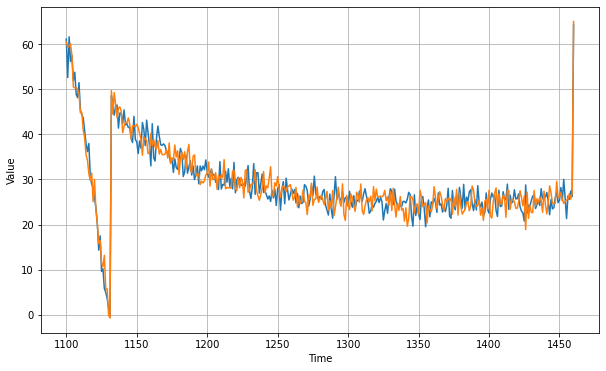

In [42]:
diff_moving_avg_plus_past = diff_moving_avg + series[split_time - 365:-365] # 1년 전 데이터에 이동 평균값 더해서 1년 후 데이터 구하는거임(여기선 마지막 365개 값을 예측하는거지)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [43]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) # mse : 오차의 제곱을 다 더하고 평균낸거
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) # mae : 차이를 절대값으로 만든 걸 다 더하고 평균낸거
# EXPECTED OUTPUT
# 8.498155
# 2.327179

19.578306
2.6011972


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

361


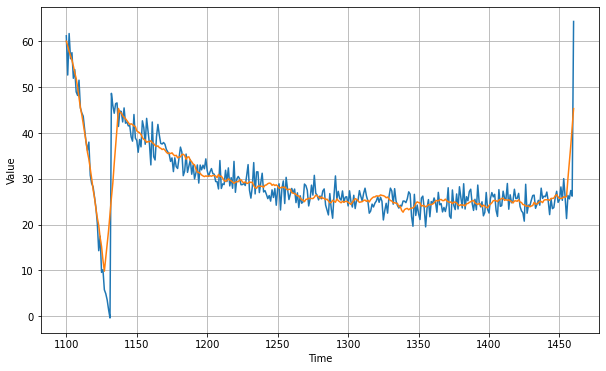

In [44]:
# 노이즈 제거
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg # moving_average_forecast : 평균값으로 노이즈 제거한다

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [45]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) 
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

19.578306
2.6011972
